# HW3: Air Quality Near Oakland University

The following utilizes the AirNow API to explore historical air quality data near Oakland University.

By: Haley McDowell

## Preliminaries

In [1349]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import commonly used libraries and magic command for inline plotting

In [1414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pytz
from IPython.display import Image
from datetime import datetime

In [1351]:
%matplotlib inline

# Introduction

AirNow is a website providing air quality data at the state and national level. It uses the official U.S. Air Quality Index (AQI) for reporting data. The data is obtained through a partnership of the U.S. Environmental Protection Agency, National Oceanic and Atmospheric Administration (NOAA), National Park Service, NASA, Centers for Disease Control, and tribal, state, and local air quality agencies. 

The AirNow API allows air quality data to be pulled from their website.

According to the AirNow website, "The EPA developed the AQI, which reports levels of ozone, particle pollution, and other common air pollutants on the same scale. An AQI reading of 101 corresponds to a level above the national air quality standard - the higher the AQI rating, the greater the health impact."

The below chart details the different AQI categories:

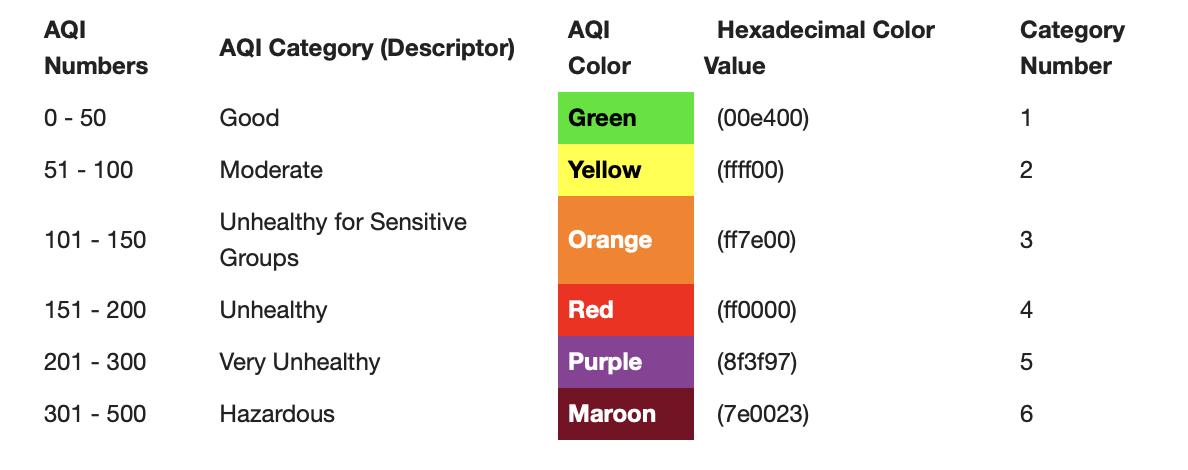

In [1352]:
Image("aqi_info.png")

## 2025 Data

The AirNow API provides air quality data from a number of sensors around the US, Canada, and Mexico. For this assignment, I will specifically be looking at data from the sensor nearest Oakland University.

In [1353]:
import requests

Looking through the API documentation (https://docs.airnowapi.org/webservices), the Observations by Monitoring Site endpoint looks to take a date range and should be able to provide historical air quality data.

Unfortunately, this endpoint does not take a zip code or coordinates and return data from the nearest sensor. Instead, it takes a geographic area of interest. Due to this, I had to come up with a coordinate range. Starting small with coordinates very close to Oakland University, I was able to gradually expand until I captured a sensor. It took some trial and error, but I was able to locate a nearby sensor. A quick Google search of the coordinates told me the nearest sensor is at a location in Sterling Heights, Michigan near 15 mile and Van Dyke. It appears from Google Maps to be located on the property of Maple Lane Golf Club.

In [1354]:
# Set geographic area of interest.

min_longitude = -83.3
min_latitude = 42.5
max_longitude = -82.9
max_latitude = 42.8

I will start by looking at Ozone data from the previous week (June 6 - June 13). The API takes dates in UTC format.

In [1355]:
# Set the start/end date and data type.

start_date = "2025-06-06T04"
end_date = "2025-06-14T03"
data = "OZONE"

The API key must also be utilized. To avoid hardcoding my key, I opted to create a .env file to store my API key.

In [1356]:
import os
from dotenv import load_dotenv, dotenv_values

load_dotenv()

# Create variable for API key value.
api_key = os.getenv("API_KEY")

I will now set the URL and other parameters needed for the API call. The API documentation (https://docs.airnowapi.org/Data/docs) was helpful for completing this.

In [1357]:
# Set the URL.

url = "https://www.airnowapi.org/aq/data/"

In [1358]:
# Set parameters.

params = {
    "bbox": f"{min_longitude},{min_latitude},{max_longitude},{max_latitude}",
    "startDate": start_date,
    "endDate": end_date,
    "parameters": data,
    "API_KEY": api_key,
    
    "datatype": "A",
    "format": "application/json",
    "verbose": "0",
    "monitorType": "0",
    "includerawconcentrations": "0" 
}

Using the above values, I will make my API request.

In [1359]:
# API request.

response = requests.get(url, params=params)
week_data = response.json()

I will now pass the JSON data into a Pandas DataFrame.

In [1360]:
# Create dataframe.

week_data_df = pd.DataFrame(week_data)
week_data_df

,Latitude,Longitude,UTC,Parameter,Unit,AQI,Category
0,42.5467,-83.0061,2025-06-06T04:00,OZONE,PPB,33,1
1,42.5467,-83.0061,2025-06-06T05:00,OZONE,PPB,33,1
2,42.5467,-83.0061,2025-06-06T06:00,OZONE,PPB,30,1
3,42.5467,-83.0061,2025-06-06T07:00,OZONE,PPB,31,1
4,42.5467,-83.0061,2025-06-06T08:00,OZONE,PPB,31,1
...,...,...,...,...,...,...,...
186,42.5467,-83.0061,2025-06-13T23:00,OZONE,PPB,37,1
187,42.5467,-83.0061,2025-06-14T00:00,OZONE,PPB,36,1
188,42.5467,-83.0061,2025-06-14T01:00,OZONE,PPB,34,1
189,42.5467,-83.0061,2025-06-14T02:00,OZONE,PPB,30,1


Looking at the data types, the UTC column is an object.

In [1361]:
week_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   191 non-null    float64
 1   Longitude  191 non-null    float64
 2   UTC        191 non-null    object 
 3   Parameter  191 non-null    object 
 4   Unit       191 non-null    object 
 5   AQI        191 non-null    int64  
 6   Category   191 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 10.6+ KB


I will change the UTC column to datetime.

In [1362]:
# Convert UTC column to datetime.

week_data_df['UTC'] = pd.to_datetime(week_data_df['UTC'])

week_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Latitude   191 non-null    float64       
 1   Longitude  191 non-null    float64       
 2   UTC        191 non-null    datetime64[ns]
 3   Parameter  191 non-null    object        
 4   Unit       191 non-null    object        
 5   AQI        191 non-null    int64         
 6   Category   191 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 10.6+ KB


The UTC column is now actually a Timestamp object. 

I am going to create a new column with the local time. To do this, I consulted this link: https://www.geeksforgeeks.org/convert-datetime-object-to-local-time-zone-in-pandas/ .

In [1363]:
# Set current timezone.
local_time = pytz.timezone('US/Eastern')

# Create column for local time.
week_data_df["local"] = week_data_df["UTC"].dt.tz_localize('UTC').dt.tz_convert(local_time)

I am going to separate the date from the time so I can group by the date to plot. I will also create a short date column for analysis later on.

In [1364]:
# Create date and time columns.

week_data_df["date"] = week_data_df["local"].dt.date
week_data_df["time"] = week_data_df["local"].dt.time
week_data_df["shortDate"] = week_data_df["local"].dt.strftime("%m-%d")

In [1365]:
week_data_df

,Latitude,Longitude,UTC,Parameter,Unit,AQI,Category,local,date,time,shortDate
0,42.5467,-83.0061,2025-06-06 04:00:00,OZONE,PPB,33,1,2025-06-06 00:00:00-04:00,2025-06-06,00:00:00,06-06
1,42.5467,-83.0061,2025-06-06 05:00:00,OZONE,PPB,33,1,2025-06-06 01:00:00-04:00,2025-06-06,01:00:00,06-06
2,42.5467,-83.0061,2025-06-06 06:00:00,OZONE,PPB,30,1,2025-06-06 02:00:00-04:00,2025-06-06,02:00:00,06-06
3,42.5467,-83.0061,2025-06-06 07:00:00,OZONE,PPB,31,1,2025-06-06 03:00:00-04:00,2025-06-06,03:00:00,06-06
4,42.5467,-83.0061,2025-06-06 08:00:00,OZONE,PPB,31,1,2025-06-06 04:00:00-04:00,2025-06-06,04:00:00,06-06
...,...,...,...,...,...,...,...,...,...,...,...
186,42.5467,-83.0061,2025-06-13 23:00:00,OZONE,PPB,37,1,2025-06-13 19:00:00-04:00,2025-06-13,19:00:00,06-13
187,42.5467,-83.0061,2025-06-14 00:00:00,OZONE,PPB,36,1,2025-06-13 20:00:00-04:00,2025-06-13,20:00:00,06-13
188,42.5467,-83.0061,2025-06-14 01:00:00,OZONE,PPB,34,1,2025-06-13 21:00:00-04:00,2025-06-13,21:00:00,06-13
189,42.5467,-83.0061,2025-06-14 02:00:00,OZONE,PPB,30,1,2025-06-13 22:00:00-04:00,2025-06-13,22:00:00,06-13


Everything looks good. As desired, I have the data from midnight on June 6 to 11 pm on June 13.

I will group by the date and take the average AQI for the day

In [1366]:
# Group by date and find the average AQI for each date.

week_avg_df = week_data_df.groupby(["date"]).mean(["AQI"])

A plot will help to visualize this.

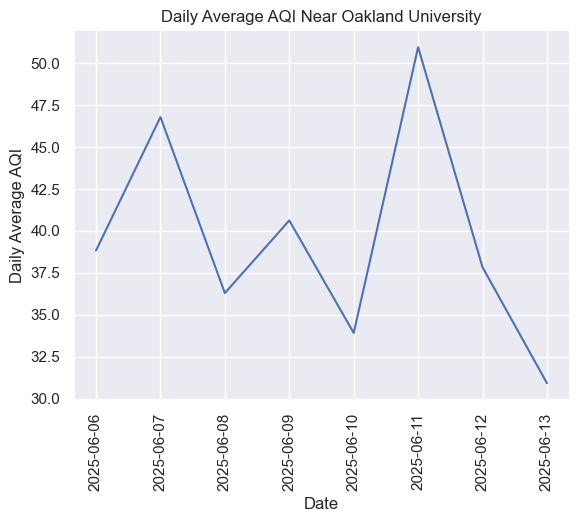

In [1423]:
# Create plot.

sns.set_theme()
sns.lineplot(x = week_avg_df.index, y = week_avg_df['AQI'])
plt.title("Daily Average AQI Near Oakland University")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Daily Average AQI")
plt.show()

The averages on 6/7 and 6/11 were highest this week. 

I will now look at the maximum AQI for each day.

In [1368]:
# Group by date and find the maximum AQI for each date.

week_max_df = week_data_df.groupby(["date"]).max(["AQI"])

A plot will be helpful here too.

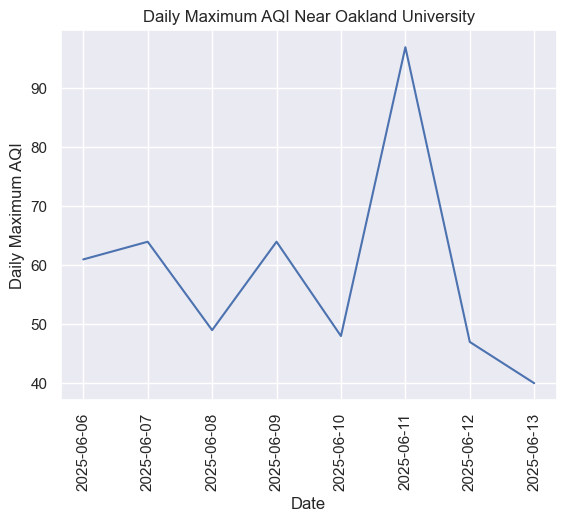

In [1424]:
# Create plot.

sns.set_theme()
sns.lineplot(x = week_max_df.index, y = week_max_df['AQI'])
plt.title("Daily Maximum AQI Near Oakland University")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Daily Maximum AQI")
plt.show()

The maximum AQI on 6/11 is significantly higher than any other day this week. An AQI over 50 equates to Moderate air quality. The daily maximum on 4 days this week are considered Moderate, 2 would be considered either Good or just barely Moderate (as they are right around 50), and only 1 day would be considered Good as it had a daily maximum AQI under 50.

When looking at the daily averages, 6/7 had an average that was higher than most of the other days. Looking at this graph, the daily maximum on 6/7 was not significantly higher than the other days. This likely indicates the AQI was high for a longer stretch of time on this day. I will now test this theory.

I first need to create a new column turning the existing time column into a string. This will allow me to use time as my x-axis.

In [1387]:
# Create column turning time into a string.

week_data_df['time_str'] = week_data_df['time'].astype(str)

Then I will pivot my existing dataframe to allow for desired plotting.

In [1388]:
# Pivot dataframe.

day_comp_df = week_data_df.pivot(index = 'time_str', columns = 'shortDate', values = 'AQI')

Now I will plot the hourly AQI for each day.

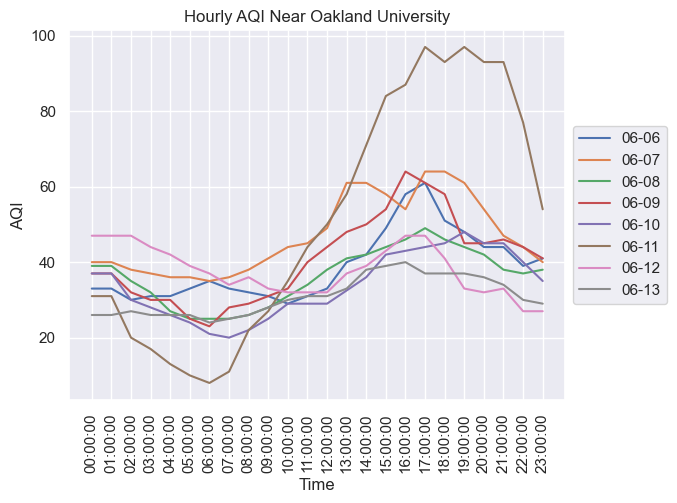

In [1425]:
# Create plot.

sns.set_theme()

for col in day_comp_df.columns:
    sns.lineplot(x = day_comp_df.index, y = day_comp_df[col], label=str(col))
    
plt.title("Hourly AQI Near Oakland University")
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("AQI")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

As seen in this plot, the AQI on 6/7 remains high from about 1pm to 7pm. Most of the other days see a quick spike in AQI lasting just a couple of hours before beginning to decrease. This confirms my suspicions that the AQI was not significantly higher than most other days, it was just higher for a longer stretch of time on 6/7.

# Comparing to Previous 4 Years

I am interested in seeing how the AQI is trending. Is air quality getting worse? Better? I would hypothesize worse, given the increase in wildfire smoke over recent years and the seeming emphasis on air quality in the media. Let's see if the data backs it up.

I am going to pull the maximum daily AQI from this same week the previous four years to see how it compares.

## 2024 Data

In [1390]:
# Set geographic area of interest.

min_longitude = -83.3
min_latitude = 42.5
max_longitude = -82.9
max_latitude = 42.8

# Set the start/end date and data type.

start_date = "2024-06-06T04"
end_date = "2024-06-14T03"
data = "OZONE"

# Set the URL.

url = "https://www.airnowapi.org/aq/data/"

# Set parameters.

params = {
    "bbox": f"{min_longitude},{min_latitude},{max_longitude},{max_latitude}",
    "startDate": start_date,
    "endDate": end_date,
    "parameters": data,
    "API_KEY": api_key,
    
    "datatype": "A",
    "format": "application/json",
    "verbose": "0",
    "monitorType": "0",
    "includerawconcentrations": "0" 
}

In [1391]:
# API request.

response = requests.get(url, params=params)
data_2024 = response.json()

In [1392]:
# Create dataframe.

data_2024_df = pd.DataFrame(data_2024)
data_2024_df

,Latitude,Longitude,UTC,Parameter,Unit,AQI,Category
0,42.5467,-83.0061,2024-06-06T04:00,OZONE,PPB,25,1
1,42.5467,-83.0061,2024-06-06T05:00,OZONE,PPB,25,1
2,42.5467,-83.0061,2024-06-06T06:00,OZONE,PPB,25,1
3,42.5467,-83.0061,2024-06-06T07:00,OZONE,PPB,22,1
4,42.5467,-83.0061,2024-06-06T08:00,OZONE,PPB,25,1
...,...,...,...,...,...,...,...
187,42.5467,-83.0061,2024-06-13T23:00,OZONE,PPB,64,2
188,42.5467,-83.0061,2024-06-14T00:00,OZONE,PPB,61,2
189,42.5467,-83.0061,2024-06-14T01:00,OZONE,PPB,61,2
190,42.5467,-83.0061,2024-06-14T02:00,OZONE,PPB,54,2


In [1393]:
# Convert UTC column to datetime.

data_2024_df['UTC'] = pd.to_datetime(data_2024_df['UTC'])

# Set current timezone.
local_time = pytz.timezone('US/Eastern')

# Create column for local time.
data_2024_df["local"] = data_2024_df["UTC"].dt.tz_localize('UTC').dt.tz_convert(local_time)

# Create date and time columns.

data_2024_df["date"] = data_2024_df["local"].dt.date
data_2024_df["time"] = data_2024_df["local"].dt.time
data_2024_df["shortDate"] = data_2024_df["local"].dt.strftime("%m-%d")

In [1394]:
# Find the daily average AQI for each date.

avg_2024_df = data_2024_df.groupby(["shortDate"]).mean(["AQI"])

# Find the max AQI for each date.

max_2024_df = data_2024_df.groupby(["shortDate"]).max(["AQI"])

## 2023 Data

In [1395]:
# Set geographic area of interest.

min_longitude = -83.3
min_latitude = 42.5
max_longitude = -82.9
max_latitude = 42.8

# Set the start/end date and data type.

start_date = "2023-06-06T04"
end_date = "2023-06-14T03"
data = "OZONE"

# Set the URL.

url = "https://www.airnowapi.org/aq/data/"

# Set parameters.

params = {
    "bbox": f"{min_longitude},{min_latitude},{max_longitude},{max_latitude}",
    "startDate": start_date,
    "endDate": end_date,
    "parameters": data,
    "API_KEY": api_key,
    
    "datatype": "A",
    "format": "application/json",
    "verbose": "0",
    "monitorType": "0",
    "includerawconcentrations": "0" 
}

In [1396]:
# API request.

response = requests.get(url, params=params)
data_2023 = response.json()

In [1397]:
# Create dataframe.

data_2023_df = pd.DataFrame(data_2023)
data_2023_df

,Latitude,Longitude,UTC,Parameter,Unit,AQI,Category
0,42.5467,-83.0061,2023-06-06T04:00,OZONE,PPB,34,1
1,42.5467,-83.0061,2023-06-06T05:00,OZONE,PPB,34,1
2,42.5467,-83.0061,2023-06-06T06:00,OZONE,PPB,29,1
3,42.5467,-83.0061,2023-06-06T07:00,OZONE,PPB,25,1
4,42.5467,-83.0061,2023-06-06T08:00,OZONE,PPB,21,1
...,...,...,...,...,...,...,...
187,42.5467,-83.0061,2023-06-13T23:00,OZONE,PPB,40,1
188,42.5467,-83.0061,2023-06-14T00:00,OZONE,PPB,39,1
189,42.5467,-83.0061,2023-06-14T01:00,OZONE,PPB,37,1
190,42.5467,-83.0061,2023-06-14T02:00,OZONE,PPB,29,1


In [1398]:
# Convert UTC column to datetime.

data_2023_df['UTC'] = pd.to_datetime(data_2023_df['UTC'])

# Set current timezone.
local_time = pytz.timezone('US/Eastern')

# Create column for local time.
data_2023_df["local"] = data_2023_df["UTC"].dt.tz_localize('UTC').dt.tz_convert(local_time)

# Create date and time columns.

data_2023_df["date"] = data_2023_df["local"].dt.date
data_2023_df["time"] = data_2023_df["local"].dt.time
data_2023_df["shortDate"] = data_2023_df["local"].dt.strftime("%m-%d")

In [1399]:
# Find the daily average AQI for each date.

avg_2023_df = data_2023_df.groupby(["shortDate"]).mean(["AQI"])

# Find the max AQI for each date.

max_2023_df = data_2023_df.groupby(["shortDate"]).max(["AQI"])

## 2022 Data

In [1400]:
# Set geographic area of interest.

min_longitude = -83.3
min_latitude = 42.5
max_longitude = -82.9
max_latitude = 42.8

# Set the start/end date and data type.

start_date = "2022-06-06T04"
end_date = "2022-06-14T03"
data = "OZONE"

# Set the URL.

url = "https://www.airnowapi.org/aq/data/"

# Set parameters.

params = {
    "bbox": f"{min_longitude},{min_latitude},{max_longitude},{max_latitude}",
    "startDate": start_date,
    "endDate": end_date,
    "parameters": data,
    "API_KEY": api_key,
    
    "datatype": "A",
    "format": "application/json",
    "verbose": "0",
    "monitorType": "0",
    "includerawconcentrations": "0" 
}

In [1401]:
# API request.

response = requests.get(url, params=params)
data_2022 = response.json()

In [1402]:
# Create dataframe.

data_2022_df = pd.DataFrame(data_2022)
data_2022_df

,Latitude,Longitude,UTC,Parameter,Unit,AQI,Category
0,42.5467,-83.0061,2022-06-06T04:00,OZONE,PPB,37,1
1,42.5467,-83.0061,2022-06-06T05:00,OZONE,PPB,37,1
2,42.5467,-83.0061,2022-06-06T06:00,OZONE,PPB,34,1
3,42.5467,-83.0061,2022-06-06T07:00,OZONE,PPB,34,1
4,42.5467,-83.0061,2022-06-06T08:00,OZONE,PPB,31,1
...,...,...,...,...,...,...,...
187,42.5467,-83.0061,2022-06-13T23:00,OZONE,PPB,44,1
188,42.5467,-83.0061,2022-06-14T00:00,OZONE,PPB,43,1
189,42.5467,-83.0061,2022-06-14T01:00,OZONE,PPB,41,1
190,42.5467,-83.0061,2022-06-14T02:00,OZONE,PPB,38,1


In [1403]:
# Convert UTC column to datetime.

data_2022_df['UTC'] = pd.to_datetime(data_2022_df['UTC'])

# Set current timezone.
local_time = pytz.timezone('US/Eastern')

# Create column for local time.
data_2022_df["local"] = data_2022_df["UTC"].dt.tz_localize('UTC').dt.tz_convert(local_time)

# Create date and time columns.

data_2022_df["date"] = data_2022_df["local"].dt.date
data_2022_df["time"] = data_2022_df["local"].dt.time
data_2022_df["shortDate"] = data_2022_df["local"].dt.strftime("%m-%d")

In [1404]:
# Find the daily average AQI for each date.

avg_2022_df = data_2022_df.groupby(["shortDate"]).mean(["AQI"])

# Find the max AQI for each date.

max_2022_df = data_2022_df.groupby(["shortDate"]).max(["AQI"])

## 2021 Data

In [1405]:
# Set geographic area of interest.

min_longitude = -83.3
min_latitude = 42.5
max_longitude = -82.9
max_latitude = 42.8

# Set the start/end date and data type.

start_date = "2021-06-06T04"
end_date = "2021-06-14T03"
data = "OZONE"

# Set the URL.

url = "https://www.airnowapi.org/aq/data/"

# Set parameters.

params = {
    "bbox": f"{min_longitude},{min_latitude},{max_longitude},{max_latitude}",
    "startDate": start_date,
    "endDate": end_date,
    "parameters": data,
    "API_KEY": api_key,
    
    "datatype": "A",
    "format": "application/json",
    "verbose": "0",
    "monitorType": "0",
    "includerawconcentrations": "0" 
}

In [1406]:
# API request.

response = requests.get(url, params=params)
data_2021 = response.json()

In [1407]:
# Create dataframe.

data_2021_df = pd.DataFrame(data_2021)
data_2021_df

,Latitude,Longitude,UTC,Parameter,Unit,AQI,Category
0,42.5467,-83.0061,2021-06-06T04:00,OZONE,PPB,44,1
1,42.5467,-83.0061,2021-06-06T05:00,OZONE,PPB,44,1
2,42.5467,-83.0061,2021-06-06T06:00,OZONE,PPB,44,1
3,42.5467,-83.0061,2021-06-06T07:00,OZONE,PPB,39,1
4,42.5467,-83.0061,2021-06-06T08:00,OZONE,PPB,36,1
...,...,...,...,...,...,...,...
187,42.5467,-83.0061,2021-06-13T23:00,OZONE,PPB,45,1
188,42.5467,-83.0061,2021-06-14T00:00,OZONE,PPB,44,1
189,42.5467,-83.0061,2021-06-14T01:00,OZONE,PPB,41,1
190,42.5467,-83.0061,2021-06-14T02:00,OZONE,PPB,37,1


In [1408]:
# Convert UTC column to datetime.

data_2021_df['UTC'] = pd.to_datetime(data_2021_df['UTC'])

# Set current timezone.
local_time = pytz.timezone('US/Eastern')

# Create column for local time.
data_2021_df["local"] = data_2021_df["UTC"].dt.tz_localize('UTC').dt.tz_convert(local_time)

# Create date and time columns.

data_2021_df["date"] = data_2021_df["local"].dt.date
data_2021_df["time"] = data_2021_df["local"].dt.time
data_2021_df["shortDate"] = data_2021_df["local"].dt.strftime("%m-%d")

In [1409]:
# Find the daily average AQI for each date.

avg_2021_df = data_2021_df.groupby(["shortDate"]).mean(["AQI"])

# Find the max AQI for each date.

max_2021_df = data_2021_df.groupby(["shortDate"]).max(["AQI"])

## Comparison

Before comparing each year, I will group the 2025 data in the same way as I did for the other 4 years.

In [1410]:
# Group by short date.

avg_2025_df = week_data_df.groupby(["shortDate"]).mean(["AQI"])
max_2025_df = week_data_df.groupby(["shortDate"]).max(["AQI"])

I will plot the daily average for each of the days across all five years.

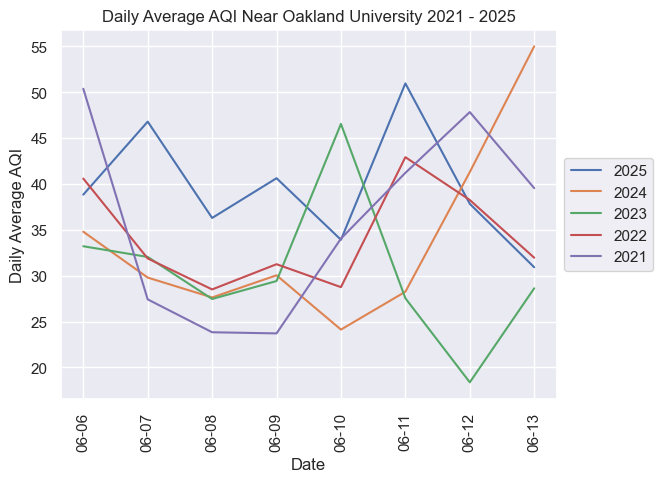

In [1426]:
# Create plot.

sns.set_theme()
sns.lineplot(x = avg_2025_df.index, y = avg_2025_df['AQI'], label = "2025")
sns.lineplot(x = avg_2024_df.index, y = avg_2024_df['AQI'], label = "2024")
sns.lineplot(x = avg_2023_df.index, y = avg_2023_df['AQI'], label = "2023")
sns.lineplot(x = avg_2022_df.index, y = avg_2022_df['AQI'], label = "2022")
sns.lineplot(x = avg_2021_df.index, y = avg_2021_df['AQI'], label = "2021")
plt.title("Daily Average AQI Near Oakland University 2021 - 2025")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Daily Average AQI")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

There does not appear to be any definitive answer as to if the air quality is getting worse or better by looking at the daily average of this particular week over the last five years. 2021 and 2025 (the two ends of the range) both had their highest daily average AQI near 50. 

The argument could be made 2025 has seen a higher daily average AQI for more consecutive days than the previous years.

I will also plot the daily maximum for each of the days across all five years.

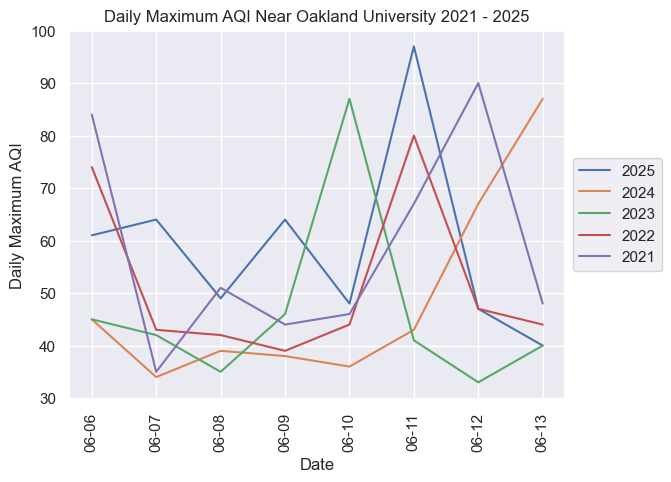

In [1427]:
# Create plot.

sns.set_theme()
sns.lineplot(x = max_2025_df.index, y = max_2025_df['AQI'], label = "2025")
sns.lineplot(x = max_2024_df.index, y = max_2024_df['AQI'], label = "2024")
sns.lineplot(x = max_2023_df.index, y = max_2023_df['AQI'], label = "2023")
sns.lineplot(x = max_2022_df.index, y = max_2022_df['AQI'], label = "2022")
sns.lineplot(x = max_2021_df.index, y = max_2021_df['AQI'], label = "2021")
plt.title("Daily Maximum AQI Near Oakland University 2021 - 2025")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Daily Maximum AQI")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

2025 does see the highest reading, but 2021, 2023, and 2024 also have a day with a significant reading. The only evidence I see supporting my theory would be the same trend as the daily average chart was showing with the daily max for 2025 tending to be higher for consecutive days compared to other years.

The only conclusion I was able to draw from looking at this particular week is the air quality stayed worse for a longer stretch of time in 2025 compared to previous years. I do not see this emerging as a trend thus far as 2024 seemed to be better than previous years.

Regardless, no day in any of the past 5 years saw an AQI category more severe than Moderate. 

For a better analysis, the date range should be expanded. I would have expanded my date range here, but the API was taking an excessive time to respond. From what I could tell, the AirNow API is not typically used to view historical data, but rather to see current conditions. I tried OpenAir as that is recommended for historical data, but found much of the data is not ingested by the API. This caused major gaps in data.